In [1]:
mname = 'se_resnext_a2'
seed = 723
fold = 0
gpu_id = 0

In [2]:
# initialize weights from this model
mname0 = 'se_resnext_a0'

In [3]:
import socket
import timeit
import time
from datetime import datetime
import os
import glob
from collections import OrderedDict
import numpy as np
import pandas as pd
import pickle
import gc
import cv2
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
import random
import PIL
import pathlib
import pathlib

import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau, StepLR
import torchvision

from skimage.exposure import histogram, equalize_hist, equalize_adapthist

import pretrainedmodels
from xception import xception

from tensorboardX import SummaryWriter

from scipy.special import logit
from sklearn.metrics import jaccard_similarity_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

import imgaug as ia
from imgaug import augmenters as iaa
import multiprocessing
import threading

from dataloaders import utils
from dataloaders import custom_transforms as tr

# from losses import CombinedLoss, BCELoss2d
import lovasz_losses as L

In [4]:
directory = './'

ori_size = 512
up_size = 512
image_size = 512

interp = cv2.INTER_AREA
# methods=[("area", cv2.INTER_AREA), 
#          ("nearest", cv2.INTER_NEAREST), 
#          ("linear", cv2.INTER_LINEAR), 
#          ("cubic", cv2.INTER_CUBIC), 
#          ("lanczos4", cv2.INTER_LANCZOS4)]

y_pad = image_size - up_size
y_min_pad = int(y_pad / 2)
y_max_pad = y_pad - y_min_pad

x_pad = image_size - up_size
x_min_pad = int(x_pad / 2)
x_max_pad = x_pad - x_min_pad

print(ori_size, up_size, image_size)

512 512 512


In [5]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [6]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [7]:
print(pretrainedmodels.pretrained_settings['se_resnext50_32x4d'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [8]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [9]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [10]:
test_file_list = list(ss.index.values)
print(file_list[:3], PATH_TO_TRAIN, len(file_list))
print(test_file_list[:3], PATH_TO_TEST, len(test_file_list))

['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0'] ./train/ 31072
['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'] ./test/ 11702


In [11]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    # return image_equalized.reshape(image.shape), cdf
    return image_equalized.reshape(image.shape)

def equalize(arr):
    arr = arr.astype('float')
    # usually do not touch the alpha channel
    # but here we do since it is yellow
    for i in range(4):
        # arr[...,i] = 255 * equalize_hist(arr[...,i])
        arr[...,i] = image_histogram_equalization(arr[...,i])                                  
    return arr



class MultiBandMultiLabelDataset(Dataset):
    BANDS_NAMES = ['_red.png','_green.png','_blue.png','_yellow.png']
    
    def __len__(self):
        return len(self.images_df)
    
    def __init__(self, images_df, 
                 base_path, 
                 image_transform=None, 
                 augmentator=None,
                 train_mode=True    
                ):
        if not isinstance(base_path, pathlib.Path):
            base_path = pathlib.Path(base_path)
            
        self.images_df = images_df.reset_index()
        self.image_transform = image_transform
        self.augmentator = augmentator
        self.images_df.Id = self.images_df.Id.apply(lambda x: base_path / x)
        self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
        self.train_mode = train_mode
        self.cache = {}
                                 
    def __getitem__(self, index):
        if index in self.cache: 
            X, y = self.cache[index]
        else:
            y = None
            X = self._load_multiband_image(index)
            if self.train_mode:
                y = self._load_multilabel_target(index)
            self.cache[index] = (X,y)
        
        # augmentator can be for instance imgaug augmentation object
        if self.augmentator is not None:
            X = self.augmentator(X)
           
        if self.image_transform is not None:
            X = self.image_transform(X)
        
        return X, y 
        
    def _load_multiband_image(self, index):
        row = self.images_df.iloc[index]
        image_bands = []
        for band_name in self.BANDS_NAMES:
            p = str(row.Id.absolute()) + band_name
            pil_channel = PIL.Image.open(p)
            image_bands.append(pil_channel)
            
        # pretend its a RBGA image to support 4 channels
        band4image = PIL.Image.merge('RGBA', bands=image_bands)

        # histogram equalize each channel
        
        arr = np.array(band4image)
        # print('arr',arr.shape)
        # if index==0: print(index,'hist before',histogram(arr))
        arr = equalize(arr)
        # if index==0: print(index,'hist after',histogram(arr))
        band4image = PIL.Image.fromarray(arr.astype('uint8'),'RGBA')
        
        return band4image

#         band3image = PIL.Image.new("RGB", band4image.size, (255, 255, 255))
#         band3image.paste(band4image, mask=band4image.split()[3]) 
#         band3image = band3image.resize((image_size,image_size), PIL.Image.ANTIALIAS)
#         return band3image
    
    
    def _load_multilabel_target(self, index):
        return list(map(int, self.images_df.iloc[index].Target.split(' ')))
    
        
    def collate_func(self, batch):
        labels = None
        images = [x[0] for x in batch]
        
        if self.train_mode:
            labels = [x[1] for x in batch]
            labels_one_hot  = self.mlb.fit_transform(labels)
            labels = torch.FloatTensor(labels_one_hot)
            
        
        return torch.stack(images)[:,:4,:,:], labels


In [12]:
class Batch(object):
    """Class encapsulating a batch before and after augmentation."""
    def __init__(self, identifiers, images, targets):
        self.identifiers = identifiers
        self.images = images
        self.images_aug = None
        self.targets = targets
        self.masks = None

class ImageLoader(object):
    """Class to load batches in the background."""

    def __init__(self, load_batch_func, nb_workers=1, queue_size=50, threaded=True):
        self.queue = multiprocessing.Queue(queue_size)
        self.workers = []
        for i in range(nb_workers):
            if threaded:
                worker = threading.Thread(target=self._load_batches, args=(load_batch_func, self.queue))
            else:
                worker = multiprocessing.Process(target=self._load_batches, args=(load_batch_func, self.queue))
            worker.daemon = True
            worker.start()
            self.workers.append(worker)

    def _load_batches(self, load_batch_func, queue):
        while True:
            queue.put(pickle.dumps(load_batch_func(), protocol=-1))

class BackgroundAugmenter(object):
    """Class to augment batches in the background (while training on
    the GPU)."""
    def __init__(self, augseq, queue_source, nb_workers, queue_size=50, threaded=False):
        assert 0 < queue_size <= 10000
        self.augseq = augseq
        self.queue_source = queue_source
        self.queue_result = multiprocessing.Queue(queue_size)
        self.workers = []
        for i in range(nb_workers):
            augseq.reseed()
            if threaded:
                worker = threading.Thread(target=self._augment_images_worker, args=(self.augseq, self.queue_source, self.queue_result))
            else:
                worker = multiprocessing.Process(target=self._augment_images_worker, args=(self.augseq, self.queue_source, self.queue_result))
            worker.daemon = True
            worker.start()
            self.workers.append(worker)

    def get_batch(self):
        """Returns a batch from the queue of augmented batches."""
        batch_str = self.queue_result.get()
        batch = pickle.loads(batch_str)
        return batch

    def _augment_images_worker(self, augseq, queue_source, queue_result):
        """Worker function that endlessly queries the source queue (input
        batches), augments batches in it and sends the result to the output
        queue."""
        while True:
            # wait for a new batch in the source queue and load it
            batch_str = queue_source.get()
            batch = pickle.loads(batch_str)

#             # augment the batch
#             if batch.images is not None and batch.masks is not None:
#                 augseq_det = augseq.to_deterministic()
#                 batch.images_aug = augseq_det.augment_images(batch.images)
#                 batch.masks_aug = augseq_det.augment_images(batch.masks)
#             elif batch.images is not None:
#                 batch.images_aug = augseq.augment_images(batch.images)
#             elif batch.masks is not None:
#                 batch.masks_aug = augseq.augment_images(batch.masks)

            if batch.images is not None:
                batch.images_aug = augseq.augment_images(batch.images)

            # send augmented batch to output queue
            queue_result.put(pickle.dumps(batch, protocol=-1))


In [13]:
# initialize image augmentation cascade
rarely = lambda aug: iaa.Sometimes(0.1, aug)
sometimes = lambda aug: iaa.Sometimes(0.25, aug)
often = lambda aug: iaa.Sometimes(0.75, aug)
seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
#         rarely(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
#         often(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
#         sometimes(iaa.GaussianBlur((0, 3.0))), # blur images with a sigma between 0 and 3.0
#         sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
#         sometimes(iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))), # emboss images
#         # search either for all edges or for directed edges
#         rarely(iaa.Sometimes(0.5,
#             iaa.EdgeDetect(alpha=(0, 0.7)),
#             iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
#         )),
#         often(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.2), per_channel=0.5)), # add gaussian noise to images
#         often(iaa.Dropout((0.0, 0.1), per_channel=0.5)), # randomly remove up to 10% of the pixels
#         # rarely(iaa.Invert(0.25, per_channel=True)), # invert color channels
#         often(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
#         often(iaa.Multiply((0.5, 1.5), per_channel=0.25)), # change brightness of images (50-150% of original value)
#         often(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)), # improve or worsen the contrast
#         # sometimes(iaa.Grayscale(alpha=(0.0, 1.0))),
#         often(iaa.Affine(
#             scale={"x": (0.6, 1.4), "y": (0.6, 1.4)}, # scale images to 60-140% of their size, individually per axis
#             translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}, # translate by -30 to +30% percent (per axis)
#             rotate=(-45, 45), # rotate by -45 to +45 degrees
#             shear=(-16, 16), # shear by -16 to +16 degrees
#             order=[0, 1], # use any of scikit-image's interpolation methods
#             cval=(0, 255), # if mode is constant, use a cval between 0 and 255
#             mode=["constant", "edge"] # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#         )),
#         sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)) # apply elastic transformations with random strengths
    ],
    random_order=True # do all of the above in random order
)

In [14]:
composed_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # tr.Normalize(mean=(0.485), std=(0.229)),
    transforms.ToTensor()])

composed_transforms_test = transforms.Compose([
    transforms.Resize(size=224),
    # tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # tr.Normalize(mean=(0.485), std=(0.229)),
    transforms.ToTensor()])

folds = pickle.load(open('folds0.pkl','rb'))

In [15]:
def parameters_string(module):
    lines = [
        "",
        "List of model parameters:",
        "=========================",
    ]

    row_format = "{name:<40} {shape:>20} ={total_size:>12,d}"
    params = list(module.named_parameters())
    for name, param in params:
        lines.append(row_format.format(
            name=name,
            shape=" * ".join(str(p) for p in param.size()),
            total_size=param.numel()
        ))
    lines.append("=" * 75)
    lines.append(row_format.format(
        name="all parameters",
        shape="sum of above",
        total_size=sum(int(param.numel()) for name, param in params)
    ))
    lines.append("")
    return "\n".join(lines)


In [16]:
%run 'se_resnext0.ipynb'

In [17]:
gc.collect()
                 
nfold = 5
seed = 723
eps = 1e-5

# Setting parameters
# use_sbd = False # Whether to use SBD dataset
nEpochs = 75  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume

p = OrderedDict()  # Parameters to include in report
p['trainBatch'] = 24  # Training batch size
p['testBatch'] = 9  # Testing batch size
useTest = True  # See evolution of the test set when training
nTestInterval = 1  # Run on test set every nTestInterval epochs
snapshot = 30  # Store a model every snapshot epochs
p['nAveGrad'] = 1  # Average the gradient of several iterations
p['lr'] = 3e-4  # Learning rate
p['step_size'] = 25
p['gamma'] = 0.5
p['wd'] = 1e-4  # Weight decay
p['momentum'] = 0.9  # Momentum
p['epoch_size'] = 15 # How many epochs to change learning rate
p['patience'] = 35 # epochs to wait for early stopping

# save_dir_root = os.path.join(os.path.dirname(os.path.abspath(__file__)))
# exp_name = os.path.dirname(os.path.abspath(__file__)).split('/')[-1]

save_dir_root = './'

# save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))
save_dir = save_dir_root + mname + '/'
os.makedirs(save_dir,exist_ok=True)
print(save_dir)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

./se_resnext_a2/



**************************************************
se_resnext_a2 fold 0
**************************************************
Number of parameters: 27,617,283
Initializing weights from se_resnext_a0/best_0.pth
Using GPU: 0 
Training on 24857 and validating on 6215
Image size: 512
Batch size: 24
Number of batches per epoch:  1036

learning rate = 0.000300
epoch 0  train 0.0958  val 0.1046  delta 0.0088  f1 0.4872*  time 455s

epoch 1  train 0.0720  val 0.1001  delta 0.0281  f1 0.5436*  time 454s

epoch 2  train 0.0668  val 0.1027  delta 0.0359  f1 0.5433   time 454s

epoch 3  train 0.0625  val 0.1029  delta 0.0404  f1 0.5554*  time 454s

epoch 4  train 0.0584  val 0.1102  delta 0.0518  f1 0.5241   time 454s

epoch 5  train 0.0562  val 0.1002  delta 0.0440  f1 0.5666*  time 455s

epoch 6  train 0.0532  val 0.1022  delta 0.0490  f1 0.5803*  time 454s

epoch 7  train 0.0509  val 0.1008  delta 0.0500  f1 0.5748   time 454s

epoch 8  train 0.0495  val 0.0981  delta 0.0486  f1 0.5974*  time 455

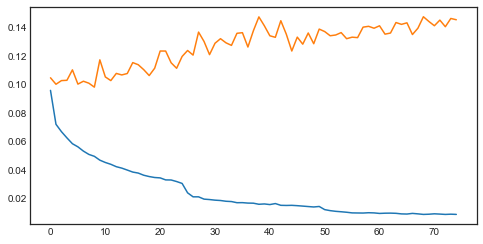

<Figure size 432x288 with 0 Axes>

In [18]:
gc.collect()

for f in range(nfold):
    
    if f != fold: continue
    
    print('')
    print('*'*50)
    print(mname + ' fold ' + str(fold))
    print('*'*50)
    bname = mname+'/'+'best_'+str(fold)+'.pth'
    
    # Network definition
    net = SE_Resnext(num_classes=28, num_filters=32, pretrained=True)
    
    print("Number of parameters:","{:,}".format(count_parameters(net)))
    # print(p.status())

    # criterion = utils.cross_entropy2d
    # criterion = torch.nn.BCELoss()
    # criterion = dice_loss
    # criterion = BCELoss2d()
    # criterion = CombinedLoss(is_weight=False).cuda()
    # criterion = L.lovasz_hinge
    # criterion = L.lovasz2_bce1
    # criterion = L.lovasz_hinge
    criterion = nn.BCEWithLogitsLoss()

    # criterionc = nn.CrossEntropyLoss()

    if resume_epoch == 0:
        if len(mname0):
            bname0 = mname0+'/'+'best_'+str(fold)+'.pth'
            print(f'Initializing weights from {bname0}')
            # load best model
            best = torch.load(bname0, map_location='cpu')
            # print(best.keys())
            net.load_state_dict(best, strict=False)
    else:
        print(f'Initializing weights from {bname}')
        # load best model
        best = torch.load(bname)
        # print(best.keys())
        net.load_state_dict(best, strict=False)

    if gpu_id >= 0:
        print('Using GPU: {} '.format(gpu_id))
        torch.cuda.set_device(device=gpu_id)
        # net.cuda()
        device = "cuda"
        # device = "cpu"
        net.train()
        net.to(device)
        
    gc.collect()
    
    # Logging into Tensorboard
    # log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
    log_dir = os.path.join('tensorboard', mname + '_' + str(fold))
    writer = SummaryWriter(log_dir=log_dir)

    # Use the following optimizer
#     optimizer = optim.SGD(net.parameters(), lr=p['lr'], momentum=p['momentum'],
#                           weight_decay=p['wd'])
    optimizer = torch.optim.Adam(net.parameters(), lr=p['lr'])
    p['optimizer'] = str(optimizer)

#     scheduler = LambdaLR(optimizer, lr_lambda=cyclic_lr)
#     scheduler.base_lrs = list(map(lambda group: 1.0, optimizer.param_groups))  
#     scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=5, verbose=True, 
#                                   threshold=0.0, threshold_mode='abs')

    scheduler = StepLR(optimizer, step_size=p['step_size'], gamma=p['gamma'])

    torch.cuda.empty_cache()

    file_list_val = [f for f in file_list if folds[f]==fold]
    file_list_train = [f for f in file_list if f not in file_list_val]
    print('Training on ' + str(len(file_list_train)) + \
          ' and validating on ' + str(len(file_list_val)))
    
 
    db_train = MultiBandMultiLabelDataset(df.loc[file_list_train], 
                                          base_path=PATH_TO_TRAIN,
                                          image_transform=composed_transforms_train)
    db_val = MultiBandMultiLabelDataset(df.loc[file_list_val], 
                                        base_path=PATH_TO_TRAIN,
                                        image_transform=composed_transforms_test)

    trainloader = DataLoader(db_train, collate_fn=db_train.collate_func,
                             batch_size=p['trainBatch'], shuffle=True,
                            num_workers=14)
    valloader = DataLoader(db_val, collate_fn=db_train.collate_func,
                           batch_size=p['testBatch'], shuffle=False,
                          num_workers=14)
    
#     # function to generate batches within ImageLoader with no arguments
#     def load_training_batch():
#         examples_batch = random.sample(list(db_train.images_df.Id.values), p['trainBatch'])
#         blist = [db_train[ex] for ex in examples_batch]
#         images = [b[0] for b in blist]
#         targets = [b[1] for b in blist]
#         return Batch(identifiers=None, images=images, targets=targets)

#     img_loader = ImageLoader(load_training_batch, nb_workers=6)
#     bg_augmenter = BackgroundAugmenter(seq, img_loader.queue, nb_workers=8)

    utils.generate_param_report(os.path.join(save_dir, mname + '.txt'), p)

    # number of batches
    num_img_tr = len(trainloader)
    num_img_ts = len(valloader)
    
    print('Image size:', image_size)
    print('Batch size:', p['trainBatch'])
    print('Number of batches per epoch: ', num_img_tr)
    # print('Learning rate: ', p['lr'])
    print('')
   
    running_loss_tr = 0.0
    running_loss_ts = 0.0
    aveGrad = 0
    bname = mname+'/'+'best_'+str(fold)+'.pth'
    # print("Training Network")
    history = {}
    history['epoch'] = []
    history['train'] = []
    history['val'] = []
    history['delta'] = []
    history['f1'] = []
    history['time'] = []
    best_val = -999
    bad_epochs = 0
    start_time = timeit.default_timer()
    total_time = 0
    prev_lr = 999

    # Main Training and Testing Loop
    for epoch in range(resume_epoch, nEpochs):

#         if (epoch > 0) and (epoch % p['epoch_size'] == 0):
#             lr_ = utils.lr_poly(p['lr'], epoch, nEpochs, 0.9)
#             print('(poly lr policy) learning rate', lr_)
#             print('')
#             optimizer = optim.SGD(net.parameters(), lr=lr_, momentum=p['momentum'],
#                                   weight_decay=p['wd'])

        scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        if lr != prev_lr: 
            print('learning rate = %.6f' % lr)
            prev_lr = lr

        net.train()
        
        train_loss = []
        
        # for ii in range(num_img_tr):
        for ii, sample_batched in enumerate(trainloader):
            
            inputs, gts = sample_batched[0], sample_batched[1]

#             # load training batch
#             time_cbatch = time.time()
            
#             batch = bg_augmenter.get_batch()
            
#             # need to transpose for pytorch model
#             inputs = np.array(batch.images_aug).astype(np.float32).transpose(0, 3, 1, 2)
            
#             gts = np.array(batch.targets).astype(int)
                          
#             inputs = torch.from_numpy(inputs).float()
#             gts = torch.from_numpy(gts).int()
            
#             time_cbatch = time.time() - time_cbatch

            inputs = inputs.type(torch.float).to(device)
            gts = gts.to(device)
            # gts = gts.type(torch.float).to(device)
            
            # predictions are on a logit scale
            logits = net(inputs)
            
            loss = criterion(logits, gts.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            
            # adamw
            for group in optimizer.param_groups:
                for param in group['params']:
                    param.data = param.data.add(-p['wd'] * group['lr'], param.data)

            optimizer.step()
            train_loss.append(loss.item())                        
            running_loss_tr += loss.item()

        # validation
        net.eval()
        
        with torch.no_grad():

            val_loss = []
            val_predictions = []
            val_targets = []
        
            for ii, sample_batched in enumerate(valloader):

                # inputs, gts = sample_batched['image'], sample_batched['gt']
                inputs, gts = sample_batched[0], sample_batched[1]

                # tta horizontal flip
                inputs2 = inputs.numpy()[:,:,:,::-1].copy()
                inputs2 = torch.from_numpy(inputs2)

                inputs = inputs.type(torch.float).to(device)
                inputs2 = inputs2.type(torch.float).to(device)

                # predictions are on a logit scale
                logits = net(inputs)
                logits2 = net(inputs2)
                logits = (logits + logits2)/2.0
                
                loss = criterion(logits, gts.to(device))

                running_loss_ts += loss.item()
                val_loss.append(loss.item())

                # save results to compute F1 on validation set
                preds = logits.cpu().detach().numpy()
                gt = gts.cpu().detach().numpy()

                val_predictions.append(preds)
                val_targets.append(gt)

            vps = np.vstack(val_predictions)
            vts = np.vstack(val_targets)
            
            # competition metric
            vf1 = f1_score(vts,(vps > 0).astype(int), average='macro')

            if vf1 > best_val:
                star = '*'
                best_val = vf1
                torch.save(net.state_dict(), bname)
                bad_epochs = 0
            else:
                star = ' '
                bad_epochs += 1
                
            # print progress
            # running_loss_ts = running_loss_ts / num_img_ts

            tl = np.mean(train_loss)
            vl = np.mean(val_loss)

            stop_time = timeit.default_timer()
            diff_time = stop_time - start_time
            total_time += diff_time/60.
            start_time = timeit.default_timer()

            print('epoch %d  train %6.4f  val %6.4f  delta %6.4f  f1 %6.4f%s  time %2.0f%s\n' % \
                  (epoch, tl, vl, vl-tl, vf1, star, diff_time, 's'))
            writer.add_scalar('loss', tl, epoch)
            writer.add_scalar('val_loss', vl, epoch)
            writer.add_scalar('delta', vl-tl, epoch)
            writer.add_scalar('val_f1', vf1, epoch)
            writer.add_scalar('time', diff_time, epoch)
            # print('Running Loss: %f\n' % running_loss_ts)
            # print('Mean Loss: %f\n' % np.mean(val_loss))
            running_loss_tr = 0
            running_loss_ts = 0

            history['epoch'].append(epoch)
            history['train'].append(tl)
            history['val'].append(vl)
            history['f1'].append(vf1)
            history['time'].append(diff_time)

            if bad_epochs > p['patience']:
                print('early stopping, best validation loss %6.4f, total time %4.1f minutes \n' % \
                      (best_val, total_time))
                break
            
    writer.close()

    # plot history
    fig, (ax_loss) = plt.subplots(1, 1, figsize=(8,4))
    ax_loss.plot(history['epoch'], history['train'], label="Train loss")
    ax_loss.plot(history['epoch'], history['val'], label="Validation loss")
    plt.show()
    plt.gcf().clear()

In [19]:
# load best model
best = torch.load(bname)
# print(best.keys())
net.load_state_dict(best)
net.eval()

SE_Resnext(
  (conv4to3): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
  (encoder): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0

In [20]:
with torch.no_grad():
    # predict validation set
    val_logits = []
    val_y = []
    # for image, mask in tqdm.tqdm(data.DataLoader(dataset_val, batch_size = 30)):
    batch = 0
    for image, y in valloader:
        # test-time augmentation with horizontal flipping
        image2 = image.numpy()[:,:,:,::-1].copy()
        image2 = torch.from_numpy(image2)
        image = image.type(torch.float).to(device)
        image2 = image2.type(torch.float).to(device)
        logits = net(image)
        logits = logits.cpu().detach().numpy()
        logits2 = net(image2)
        logits2 = logits2.cpu().detach().numpy()
        logits = (logits + logits2)/2.0
        val_logits.append(logits)

        y = y.cpu().detach().numpy()
        val_y.append(y)

        batch += 1

    vls = np.vstack(val_logits)
    vys = np.vstack(val_y)

    print(vls.shape, vys.shape)

(6215, 28) (6215, 28)


In [21]:
# save out-of-fold predictions
oof_ids = file_list_val
poof = vls.copy()
yoof = vys.copy()

oof = [oof_ids, poof, yoof]
fname = 'oof/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(oof,open(fname,'wb'))
print(fname)

oof/se_resnext_a2_0.pkl



f1_best 0.7025764032241452
threshold_best -1.0



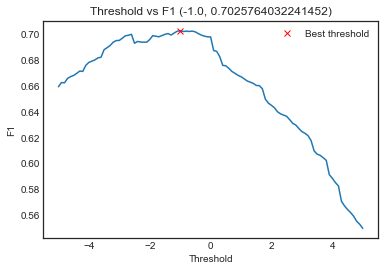

-216.87411 -21.474232 70.13139 (174020,)


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


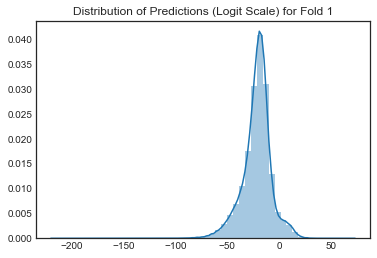

<Figure size 432x288 with 0 Axes>

In [50]:
# grid search for best threshold
# note predictions and thresholds are on logit scale
thresholds = np.linspace(-5, 5, 101)
scores = np.array([f1_score(vys, (vls > t).astype(int), average='macro') \
                 for t in thresholds])

threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('f1_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

vf = vls.flatten()
print(vf.min(),vf.mean(),vf.max(),vf.shape)
sns.distplot(vf)
plt.title("Distribution of Predictions (Logit Scale) for Fold " + str(fold+1))
plt.show()
plt.gcf().clear()

In [23]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(vys[:,i], (vls[:,i] > threshold_best).astype(int)) \
       for i in range(vys.shape[1])]
fm = [f1_score(vys[:,i], (vls[:,i] > threshold_best).astype(int)) \
       for i in range(vys.shape[1])]
for i in range(vys.shape[1]):
    print(LABEL_MAP[i])
    print(cm[i], '%4.2f' % fm[i])
    print('')

Nucleoplasm
[[3219  482]
 [ 235 2279]] 0.86

Nuclear membrane
[[5959   26]
 [  40  190]] 0.85

Nucleoli
[[5381  138]
 [ 148  548]] 0.79

Nucleoli fibrillar center
[[5832   71]
 [ 128  184]] 0.65

Nuclear speckles
[[5771   68]
 [ 120  256]] 0.73

Nuclear bodies
[[5568  114]
 [ 273  260]] 0.57

Endoplasmic reticulum
[[5977   53]
 [  56  129]] 0.70

Golgi apparatus
[[5575   89]
 [ 115  436]] 0.81

Peroxisomes
[[6208    0]
 [   3    4]] 0.73

Endosomes
[[6204    1]
 [   5    5]] 0.62

Lysosomes
[[6210    0]
 [   1    4]] 0.89

Intermediate filaments
[[5972   27]
 [  65  151]] 0.77

Actin filaments
[[6040   28]
 [  43  104]] 0.75

Focal adhesion sites
[[6080   22]
 [  40   73]] 0.70

Microtubules
[[5989   22]
 [  34  170]] 0.86

Microtubule ends
[[6211    0]
 [   2    2]] 0.67

Cytokinetic bridge
[[6103   17]
 [  43   52]] 0.63

Mitotic spindle
[[6163   10]
 [  21   21]] 0.58

Microtubule organizing center
[[5991   30]
 [  87  107]] 0.65

Centrosome
[[5841   63]
 [ 128  183]] 0.66

Lipid dr

In [24]:
np.mean(fm)

0.7025764032241452

0.4285714285714286 0.8742288459244767 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


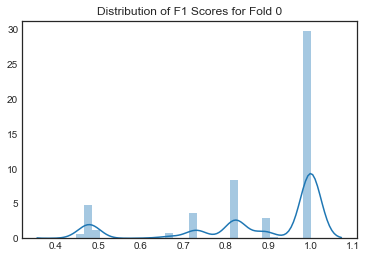

<Figure size 432x288 with 0 Axes>

In [25]:
f1b = np.array([f1_score(y, (l > threshold_best).astype(int), average='macro') \
                 for y,l in zip(vys,vls)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of F1 Scores for Fold " + str(fold))
plt.show()
plt.gcf().clear()

In [26]:
len(f1b)

6215

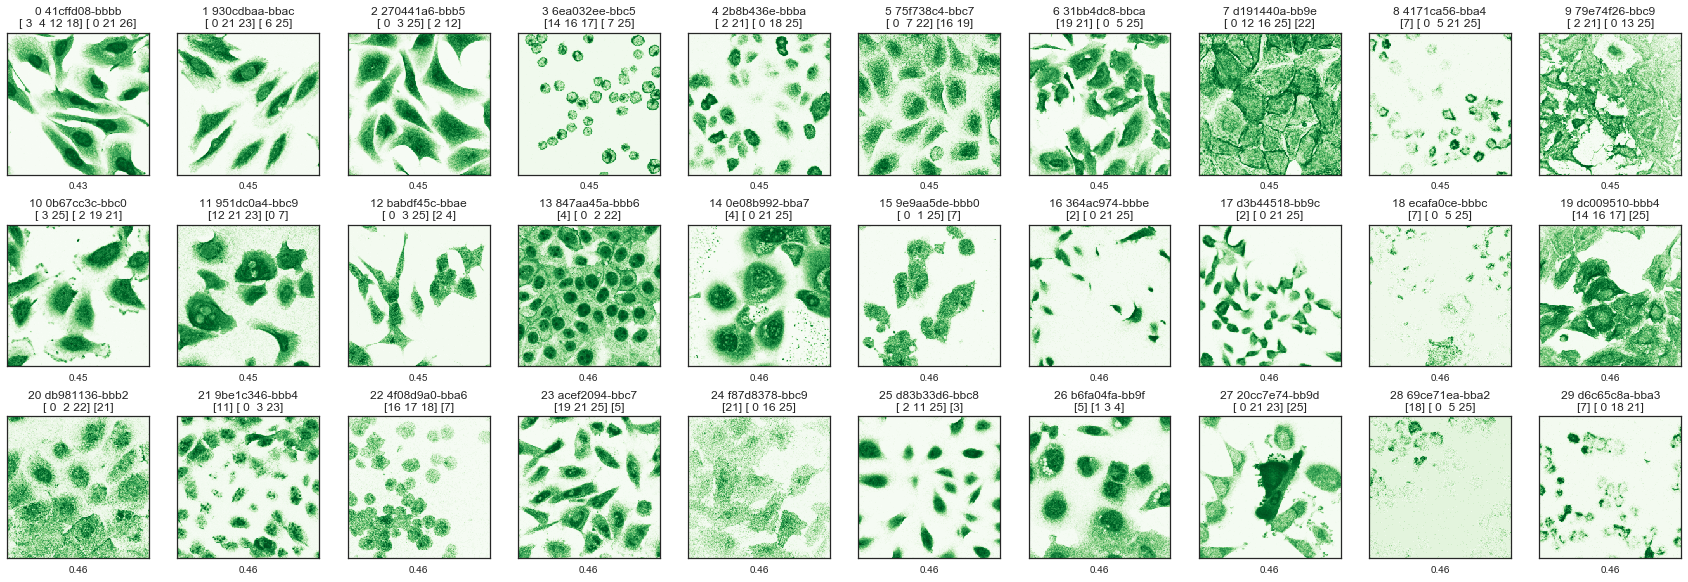

<Figure size 432x288 with 0 Axes>

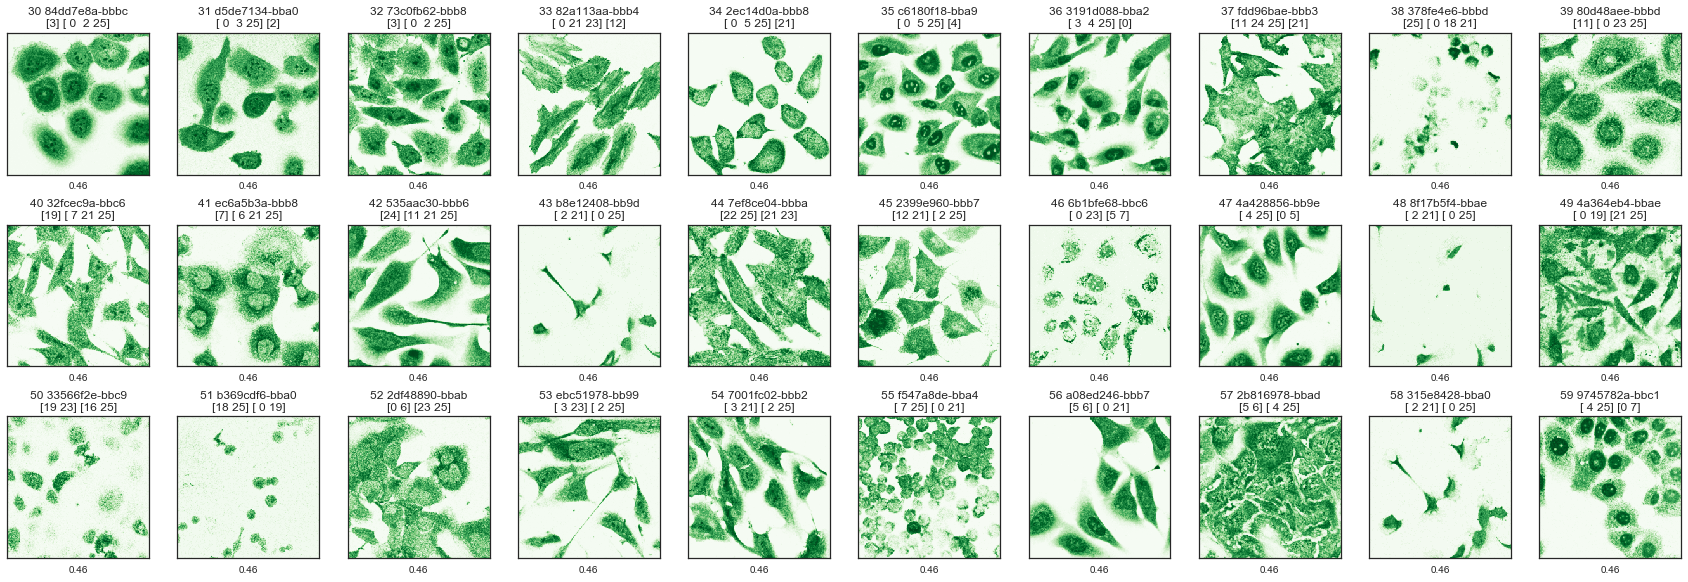

<Figure size 432x288 with 0 Axes>

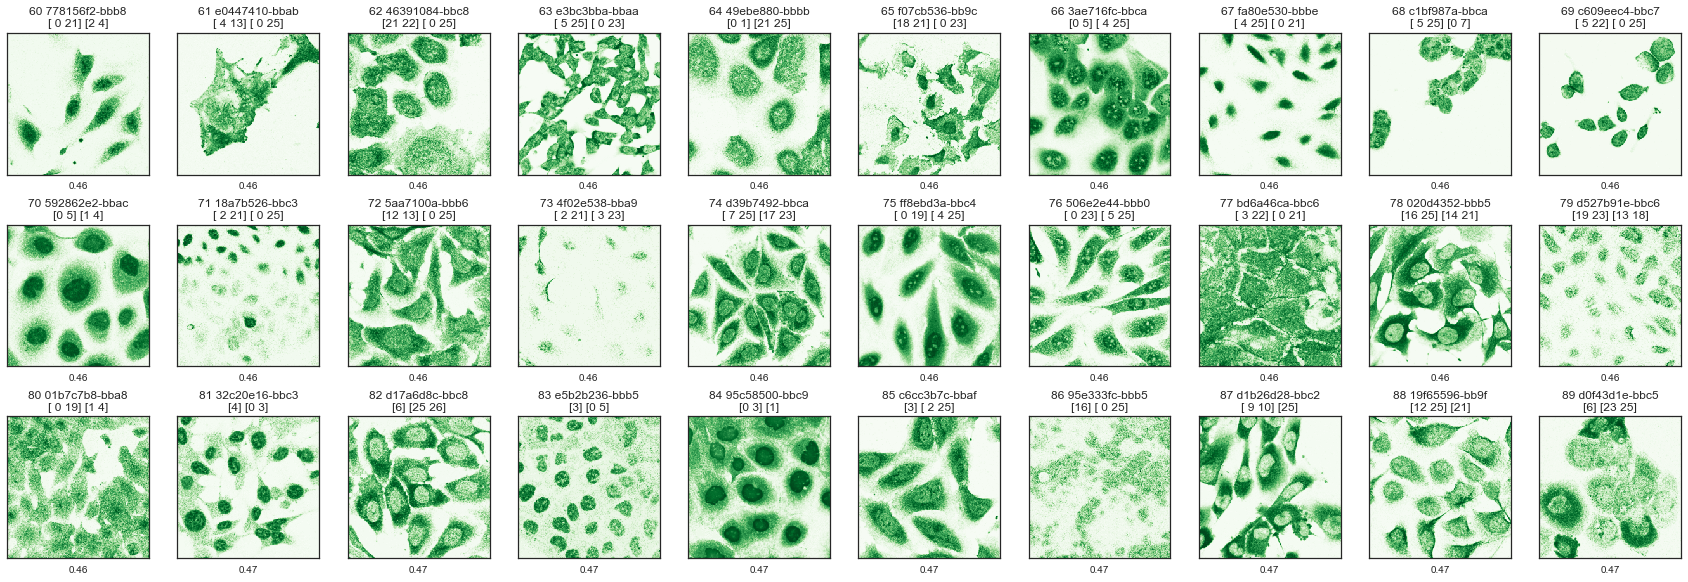

<Figure size 432x288 with 0 Axes>

In [49]:
# plot validation images with scores
# sort from worst to best
order = f1b.argsort()
max_images = 90
# max_images = len(file_list_val)
start = 0
# start = 200
grid_width = 10
grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)

file_list_val_reordered = [file_list_val[order[i]] for i,f in enumerate(file_list_val)]

for i, idx in enumerate([file_list_val_reordered[i] for i in range(start,(start+max_images))]):
    imod = i % 30
    if imod == 0:
        fig, axs = plt.subplots(3, 10, figsize=(30, 10))
    img, y = db_val[order[i]]

    img = img.data.numpy()[1]
    img = img[y_min_pad:(image_size - y_max_pad), x_min_pad:(image_size - x_max_pad)]

    true = np.nonzero(vys[order][start+i])
    true_str = ' '.join(map(str, true))
    pred = np.nonzero((vls[order][start+i] > threshold_best).astype(int))
    pred_str = ' '.join(map(str, pred))
    ax = axs[int(imod / grid_width), imod % grid_width]
    ax.imshow(img, cmap='Greens')
    ax.set_title(str(i) + '   ' + idx[:13] + '\n' + true_str + '  ' + pred_str)
    # ax.set_xlabel(str(round(ioub[i], 3)))
    ax.set_xlabel('%4.2f' % (f1b[order][start+i]))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if imod == 29:
        # plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, Top-right: salt coverage, Bottom-left: depth, Bottom-right: IOU")
        plt.show()
        plt.gcf().clear()
        gc.collect()    

In [44]:
idx

'd0f43d1e-bbc5-11e8-b2bc-ac1f6b6435d0'

In [28]:
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [29]:
db_test = MultiBandMultiLabelDataset(ss, train_mode=False,
                                    base_path=PATH_TO_TEST,
                                    image_transform=composed_transforms_test)

In [30]:
testloader = DataLoader(db_test, collate_fn=db_test.collate_func,
                       batch_size=p['testBatch'], shuffle=False,
                      num_workers=14)

In [31]:
with torch.no_grad():
    print('predicting test set for bagging')
    test_predictions = []
    
    # for image in tqdm.tqdm(data.DataLoader(test_dataset, batch_size = 30)):
    for image in testloader:
        image2 = image[0].numpy()[:,:,:,::-1].copy()
        image2 = torch.from_numpy(image2)
        image = image[0].type(torch.float).to(device)
        image2 = image2.type(torch.float).to(device)
        logits = net(image)
        logits = logits.cpu().detach().numpy()
        logits2 = net(image2)
        logits2 = logits2.cpu().detach().numpy()
        logits = (logits + logits2)/2.0

        test_predictions.append(logits)

    test_predictions_stacked = np.vstack(test_predictions)

    ptest = test_predictions_stacked

predicting test set for bagging


In [32]:
ptest.shape

(11702, 28)

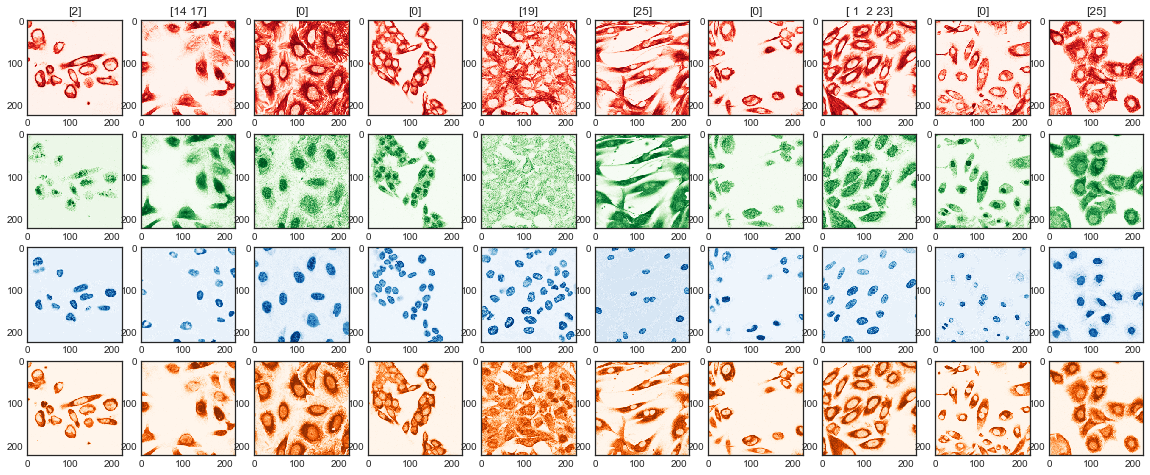

<Figure size 432x288 with 0 Axes>

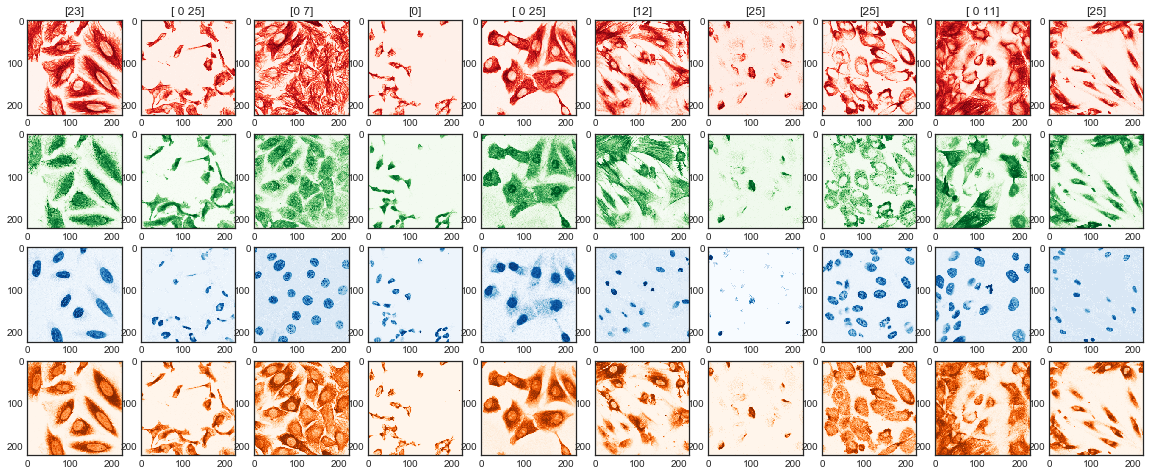

<Figure size 432x288 with 0 Axes>

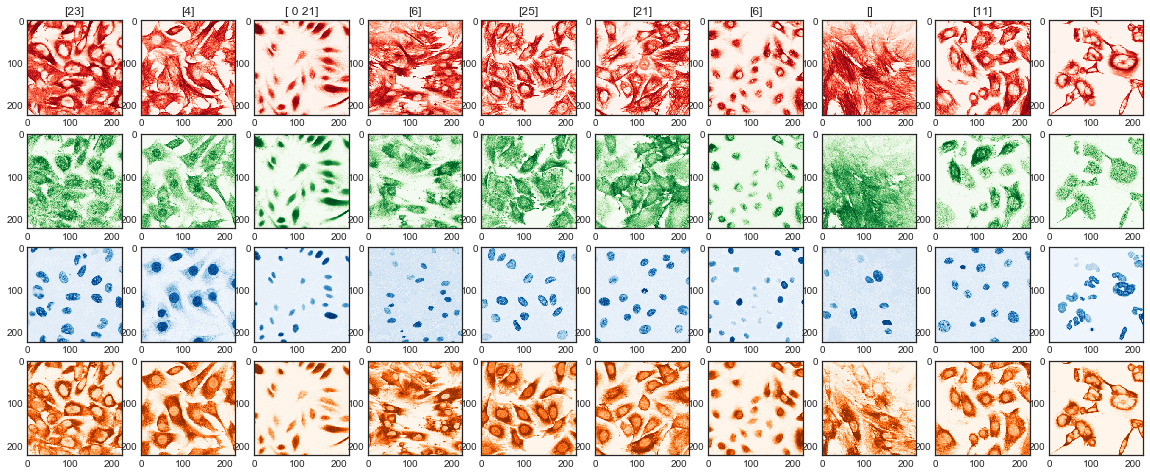

<Figure size 432x288 with 0 Axes>

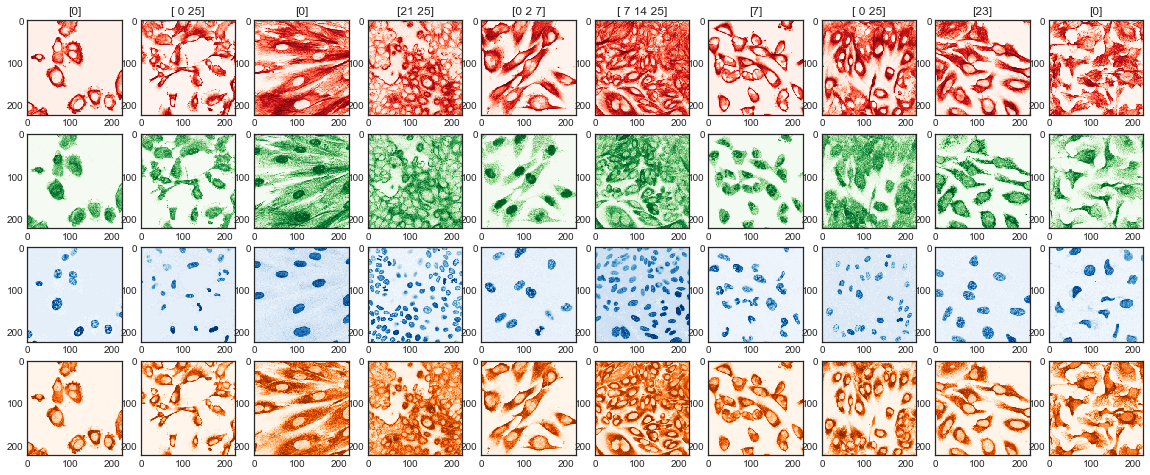

<Figure size 432x288 with 0 Axes>

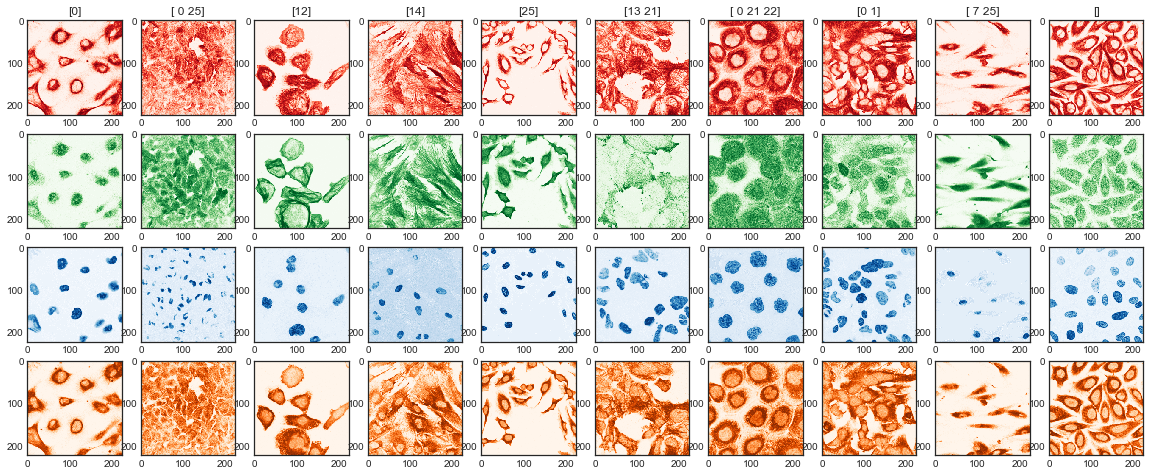

<Figure size 432x288 with 0 Axes>

In [33]:
# show some test images
nshow = 50
start = np.random.randint(len(test_file_list)-nshow)
stop = start + nshow
grid_width = 10
grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)
ni = 10
for j in range(int(start/10),int(stop/10)):
    jj = j*10
    fig, axs = plt.subplots(4, ni, figsize=(20,8))
    for i in range(ni):
        img = db_test[jj+i]
        img = img[0].data.numpy()
        img = img[:,y_min_pad:(image_size - y_max_pad),
                    x_min_pad:(image_size - x_max_pad)]
        # img = cv2.resize(img,(ori_size,ori_size),interpolation=interp)
        pred = np.nonzero((test_predictions_stacked[jj+i] > threshold_best).astype(int))
        # pred_str = list(pred)
        # pred_str = np.char.mod('%d', pred)
        # pred_str = " ".join(pred_str)
        pred_str = ' '.join(map(str, pred))
        axs[0][i].imshow(img[0], cmap="Reds")
        axs[1][i].imshow(img[1], cmap="Greens")
        axs[2][i].imshow(img[2], cmap="Blues")
        axs[3][i].imshow(img[3], cmap="Oranges")
        axs[0][i].set_title(pred_str)
    # fig.suptitle("Top row: original, bottom row: green channel")
    plt.show()
    plt.gcf().clear()

#     # clean up to save on memory accumulation across folds
#     del net
#     del inputs, gts
#     del image, image2
#     del writer, scheduler, optimizer
#     del y_pred, y_pred2
#     torch.cuda.empty_cache()
#     gc.collect()

In [34]:
sub = [test_file_list, ptest]
fname = 'sub/'+mname+'_'+str(fold)+'_bag.pkl'
pickle.dump(sub,open(fname,'wb'))
print(fname)

sub/se_resnext_a2_0_bag.pkl


In [35]:
ptest.shape

(11702, 28)